# Spectrum Exploration

#### In this notebook I create functions that helped me determine using A560 as the concentration wavelength for regression

# Imports

In [5]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

from os.path import join as pjoin

import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

pd.options.display.max_rows = 100

# Data

In [6]:
path= '../data_o/calibration/single_species_calibration/parsed_data'

#load data
df = pd.read_csv(pjoin(path, 'ss_total_spectrum.csv'), index_col=0)

In [7]:
df[df['row']=='H']['560']
df[df['col']==12]['560']

well
H1     0.4360
H2     0.4074
H3     0.3273
H4     0.3222
H5     0.2957
H6     0.2601
H7     0.2200
H8     0.1940
H9     0.1611
H10    0.1282
H11    0.0949
H12    0.0850
Name: 560, dtype: float64

well
A12    0.3505
B12    0.3197
C12    0.2677
D12    0.2333
E12    0.2051
F12    0.1370
G12    0.1091
H12    0.0850
Name: 560, dtype: float64

In [8]:
# subtract 96th well's values from the rest as this 
# is the control well, i.e. BLANK
for col in df.columns[4:].values:
    #subtract 'blank' well values
    df.loc[:,col] = df.loc[:,col] - df.loc['H12',col]

# Explore

In [9]:
hwells = df[df.index.str.contains('H')]
zwells = df[df.index.str.contains('12')]
rwells = hwells.append(zwells).drop(['row', 'col'], axis=1)
#lambdas = [440, 485, 520, 560, 600, 635, 680, 720, 750, 800]
lambdas = [440, 485, 560, 600, 680, 720, 750]

In [10]:
def corr_map(dframe, lambdas, method='pearson'):
    """Plots the minimum of the pairwise correlations give, and is used to find
    the best possible Regress TO wavelength. This is the one that is least correlated
    to 720 AND 680... 
    
    The difference between the correlations to 720 and 680 is then taken by hmap_diffs
    with the thinking being that the greater the difference will show
    """
    corr = dframe.corr(method=method)
    crmp = corr.style.background_gradient(cmap='coolwarm')
    cmin  = pd.DataFrame(pd.Series(corr.min(), name='min'))
    cmin['x'] = [int(i) for i in corr.index.values]
    cmin = cmin[['x','min']]
    
    #print(cmin)
    
    fig,ax = plt.subplots(figsize=(8,5))
    cmin.plot(x='x', y='min', ax=ax,  style='-.')
    ax.vlines(x=lambdas, ymin=cmin['min'].min(), ymax=cmin['min'].max(), colors=['y', 'r'] )
    
    ax.set_ylabel("Min Pearson-Corr Values")
    ax.set_xlabel('λ')
    ax.set_title("λ-λ Correlation Minimum")
    
    'here'
    hmap_diffs(corr, lambdas)
    
    'here2'
    hmap_minsum(corr,lambdas)
                         

In [11]:
def hmap_diffs(hmap, lambdas):

    hdf = hmap.loc[['680','720']]
    hdf.loc['mindifs'] = pd.Series(hdf.loc['680'] - hdf.loc['720']).abs()
    hdf.loc['x'] = [int(i) for i in hdf.columns.values]
    hdf = hdf.transpose()
    hdf.head()
    
    fig,ax = plt.subplots(figsize=(8,5))
    hdf.plot(x='x' ,y='mindifs',style='-.', ax=ax)
    ax.vlines(x=lambdas, ymin=hdf['mindifs'].min(), ymax=hdf['mindifs'].max(), colors=['y', 'r'])
    
        
    ax.set_ylabel("Difference of Min Pearson-Corr Values")
    ax.set_xlabel('λ')
    ax.set_title("λ-λ Correlation Minimum Differences")
        


In [13]:
def hmap_minsum(hmap, lambdas):

    hdf = hmap.loc[['680','720']]
    hdf.loc['minsums'] = pd.Series((hdf.loc['680'] + hdf.loc['720'])).abs()
    hdf.loc['x'] = [int(i) for i in hdf.columns.values]
    hdf = hdf.transpose()
    
    fig,ax = plt.subplots(figsize=(8,5))
    hdf.plot(x='x' ,y='minsums',style='-.', ax=ax)
    ax.vlines(x=lambdas, ymin=hdf['minsums'].min(), ymax=hdf['minsums'].max(), colors=['y', 'r'])
    

    ax.set_ylabel("Sums of Min Pearson-Corr Values")
    ax.set_xlabel('λ')
    ax.set_title("λ-λ Correlation Minimum Sums")
    ax.legend(loc='lower left')
    
    print(hdf)

          680       720   minsums      x
320  0.970453  0.981529  1.951982  320.0
325  0.971703  0.980739  1.952442  325.0
330  0.974354  0.978741  1.953095  330.0
335  0.977294  0.976150  1.953444  335.0
340  0.978914  0.974616  1.953530  340.0
345  0.979064  0.974564  1.953628  345.0
350  0.978362  0.975427  1.953789  350.0
355  0.978083  0.975831  1.953914  355.0
360  0.978740  0.975242  1.953982  360.0
365  0.980141  0.973859  1.954000  365.0
370  0.981761  0.972199  1.953959  370.0
375  0.983750  0.969829  1.953579  375.0
380  0.985513  0.967388  1.952901  380.0
385  0.987022  0.965068  1.952089  385.0
390  0.987828  0.963729  1.951558  390.0
395  0.988714  0.962172  1.950886  395.0
400  0.990422  0.958879  1.949301  400.0
405  0.992610  0.953960  1.946570  405.0
410  0.995469  0.945708  1.941177  410.0
415  0.997113  0.939226  1.936339  415.0
420  0.998082  0.934282  1.932364  420.0
425  0.998690  0.930333  1.929023  425.0
430  0.999323  0.924859  1.924183  430.0
435  0.999738  0

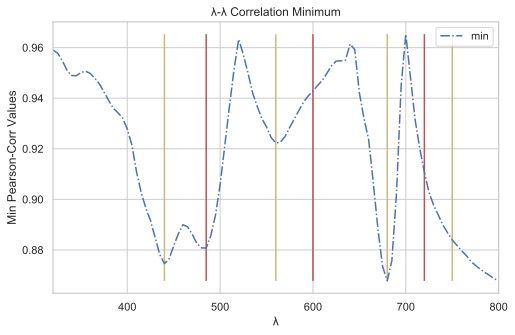

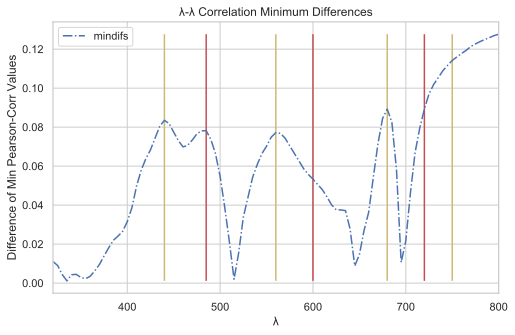

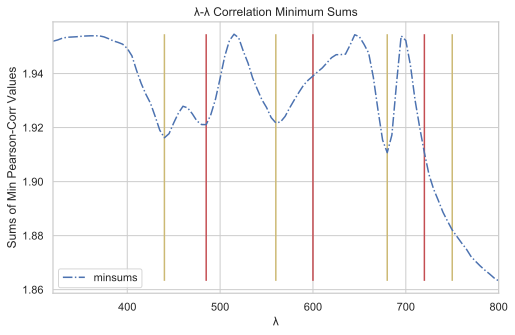

In [14]:
hmap_pearson = corr_map(rwells, lambdas)
#hmap_kendall = corr_map(rwells, lambdas, method='kendall')
#hmap_spearman = corr_map(rwells, lambdas, method='spearman')

In [17]:
#hmap_diffs(hmap_pearson, lambdas)
#hmap_diffs(hmap_kendall, lambdas)
#hmap_diffs(hmap_spearman, lambdas)

DataFrame.corr() is as

The modeling approach has been to apply Beer-Lambert's Law such that we determine the extinction coefficients (k) for bacteria and chlamy at two predetermined wavelengths (A680, A720) as these are the wavelengths that the PBR experiments measure and no other. We then regress back to another wavelength (and eventually back to cell counts) and use these values to get a ratio that we can compare against other empirical ratio data from the same exeperiment. In order to determine which other wavelength we should regress back to, we need to find one which is least correlated to '680' and '720'. This is done to avoid collinearity effects

To achieve this we looked at chlamy and bacteria gradients at the visible light spectrum and took their correlation values. 

that Looking at the bacteria and chalmy under the teacan microplate at the entire visible light spectrum allows us to determine which OTHER wavelength we can use as our response variable. The best wavelength other than 680 and 720 would be those which have 

basis for the model
My objective here was to try and determine which wavele

In [27]:
# look at the interesting parts of the 96 plate
# A1, A12, H1, H12
hwells = df[df.index.str.contains('H')]
zwells = df[df.index.str.contains('12')]
wells = ['A1', 'A12', 'H1', 'H12']
wells = ['A1', 'B12', 'H3', 'H12']

In [28]:
cwellst = df.loc[wells].transpose().drop(labels=['row', 'col'], axis=0)
hwellst = hwells.transpose().drop(labels=['row', 'col'], axis=0)
zwellst = zwells.transpose().drop(labels=['row', 'col'], axis=0)


In [29]:
cwellst.head()
hwellst.head()
zwellst.head()

well      A1     B12      H3     H12
320   1.2715  0.7592   0.867  0.4316
325   1.2378  0.7264  0.8353  0.4019
330   0.8349  0.3207  0.4341       0
335   0.8356  0.3166  0.4363       0
340   0.8319   0.313  0.4353       0

well      H1      H2      H3      H4      H5      H6      H7      H8      H9  \
320   1.0345  1.0014   0.867  0.8479  0.7856  0.7431  0.6808  0.6348  0.5597   
325   1.0036  0.9701  0.8353  0.8166  0.7553   0.712  0.6496  0.6033  0.5304   
330   0.6053  0.5715  0.4341  0.4148  0.3557  0.3105  0.2478  0.2007  0.1294   
335    0.611  0.5765  0.4363  0.4167  0.3586  0.3117  0.2482  0.2008  0.1306   
340   0.6115  0.5766  0.4353  0.4158  0.3586  0.3107  0.2472  0.1995  0.1309   

well     H10         H11     H12  
320    0.501      0.4401  0.4316  
325   0.4717      0.4111  0.4019  
330   0.0706  0.00959998       0  
335   0.0712  0.00999999       0  
340   0.0714      0.0101       0

well     A12     B12     C12     D12     E12     F12     G12     H12
320   0.8139  0.7592  0.6893   0.634  0.5957   0.507  0.4646  0.4316
325     0.78  0.7264  0.6568  0.6024  0.5646   0.476  0.4349  0.4019
330   0.3728  0.3207  0.2517  0.1981  0.1606  0.0726  0.0323       0
335   0.3676  0.3166  0.2483  0.1954  0.1585  0.0711  0.0318       0
340   0.3625   0.313  0.2451  0.1931  0.1566  0.0698  0.0312       0

In [30]:
slambdas = [str(i) for i in lambdas]

In [31]:
cwellst['wav'] = cwellst.index.values.astype(int)
hwellst['wav'] = hwellst.index.values.astype(int)
zwellst['wav'] = zwellst.index.values.astype(int)

In [32]:

cwellst.head()

well      A1     B12      H3     H12  wav
320   1.2715  0.7592   0.867  0.4316  320
325   1.2378  0.7264  0.8353  0.4019  325
330   0.8349  0.3207  0.4341       0  330
335   0.8356  0.3166  0.4363       0  335
340   0.8319   0.313  0.4353       0  340

In [33]:
def quickplot():

    fig, ax = plt.subplots(figsize=(9,6))
    cwellst.plot(x='wav', style='.', ax=ax)
    lambdas = [440, 485, 560, 600, 680, 720, 750]    
    ax.vlines(x=lambdas, ymin=0, ymax=1.4, colors=['y', 'r'], alpha=.85)
    
    
    
    ax.set_ylabel("Absorbance")
    ax.set_xlabel('λ')
    ax.set_title("Specific Well's Absorbance Spectrum")
    
    
    ax.legend(loc='upper left')
    #ax.hlines(y=[.26, .35, .52], xmin=350, xmax=600)
    # 0 bacteria + chlamy (MAX)
    # 11 bacteria only
    # 84 chlamy only
    # 95 BLANK

    # a metabolite in the medium must be absorbing at the lower wavelengths


    # What is the sum of the values at 560:
        # b = .26
        # c = .35
        # ---------
            # .61


    # 560T = .52

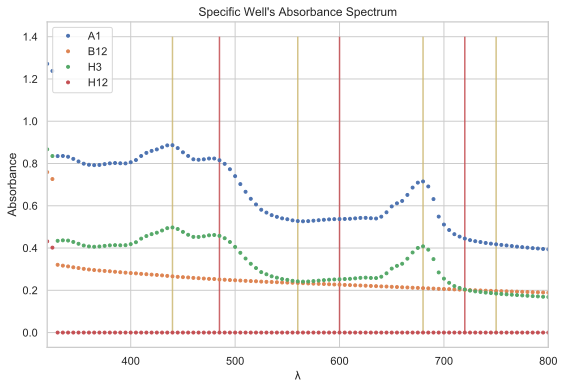

In [34]:
quickplot()


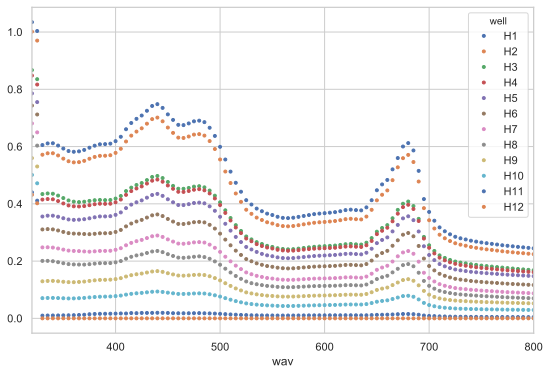

In [17]:
fig, ax = plt.subplots(figsize=(9,6))
hwellst.plot(x='wav', style='.', ax=ax)

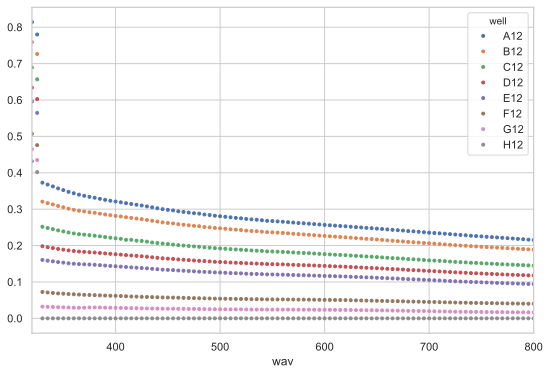

In [18]:
fig, ax = plt.subplots(figsize=(9,6))
zwellst.plot(x='wav', style='.', ax=ax)

    
    In the above graph I note that at higher-energe wavelengths the bacterial strain present at A12 tends to absorb more light; and that the absorbance gradually decreases as the wavelength increaes. Recall that the concentration of bacterium inside this well is constant, thus the decrease here is due to less light being absorbed. As the wavelength increases the contents of the bacterial cell are much smaller than the lightwave itself thus they are less readily absorbed. We do not yet know what the cell count at this well is, which is extremely unfortunate.

In [19]:
##### lambdas = [440, 485, 560, 600, 680, 720, 750]    


df[['435','440','445', '480','485','490','510', '555','560','565',
   '595','600','605', '675','680','685', '715','720','725','745','750','755']].corr().style.background_gradient(cmap='coolwarm')

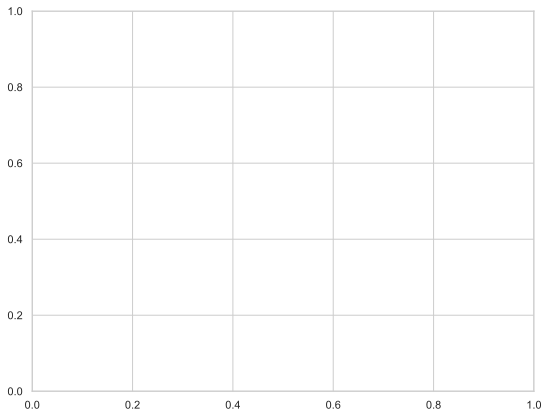

In [20]:
fig,ax = plt.subplots(figsize=(9,7))
df.iloc[:,3:].corr().style.background_gradient(cmap='coolwarm')

In [21]:
regress_to = ['440', '480', '500', '560', '635', '680', '720', '750', '800']

In [22]:
hwells.iloc[:,5:].corr().style.background_gradient(cmap='coolwarm')

In [23]:
rwells = hwells.append(zwells)
rwells.head()

row  col     320     325     330     335     340     345     350     355  \
well                                                                            
H1     H    1  1.0345  1.0036  0.6053  0.6110  0.6115  0.6035  0.5930  0.5844   
H2     H    2  1.0014  0.9701  0.5715  0.5765  0.5766  0.5689  0.5578  0.5487   
H3     H    3  0.8670  0.8353  0.4341  0.4363  0.4353  0.4288  0.4201  0.4119   
H4     H    4  0.8479  0.8166  0.4148  0.4167  0.4158  0.4097  0.4013  0.3943   
H5     H    5  0.7856  0.7553  0.3557  0.3586  0.3586  0.3549  0.3497  0.3454   

      ...     755     760     765     770     775     780     785     790  \
well  ...                                                                   
H1    ...  0.2625  0.2602  0.2579  0.2553  0.2535  0.2516  0.2497  0.2480   
H2    ...  0.2410  0.2390  0.2367  0.2343  0.2324  0.2307  0.2289  0.2275   
H3    ...  0.1826  0.1808  0.1791  0.1774  0.1756  0.1741  0.1725  0.1710   
H4    ...  0.1746  0.1728  0.1710  0.1693  0.1676  0.1664  0.1649  0.1638   
H5    ...  0.1577  0.1565  0.1551  0.1538  0.1525  0.1516  0.1505  0.1496   

         795     800  
well                  
H1    0.2462  0.2448  
H2    0.2258  0.2243  
H3    0.1695  0.1682  
H4    0.1625  0.1614  
H5    0.1485  0.1476  

[5 rows x 99 columns]

In [24]:
hmap = rwells.iloc[:,2:].corr(method='spearman')#.style.background_gradient(cmap='coolwarm')
#rwells.iloc[:,2:].corr().min()
#hmap

In [25]:
hmap.loc[['680','720']].style.background_gradient(cmap='coolwarm')

In [26]:
hdf = hmap.loc[['680','720']]
hdf.loc['diff'] = pd.Series(hdf.loc['680'] - hdf.loc['720']).abs()
hdf.loc['x'] = [int(i) for i in hdf.columns.values]
hdf = hdf.transpose()
hdf.head()

680       720      diff      x
320  0.977427  0.980436  0.003010  320.0
325  0.977427  0.980436  0.003010  325.0
330  0.977427  0.980436  0.003010  330.0
335  0.978932  0.978932  0.000000  335.0
340  0.983446  0.974417  0.009029  340.0

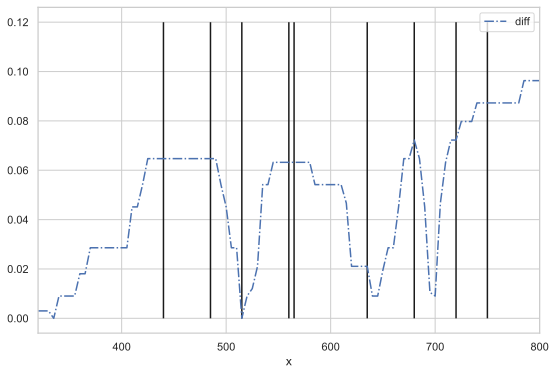

In [27]:
fig, ax = plt.subplots(figsize=(9,6))
hdf.plot(x='x' ,y='diff',style='-.', ax=ax)
ax.vlines(x=[440, 485, 515, 560, 565, 635, 680, 720, 750], ymin=0, ymax=.12)

In [28]:
corr_min = pd.DataFrame(pd.Series(rwells.iloc[:,2:].corr().min(), name='min'))
# create an x-axis to be able to set vertical lines
corr_min['x'] = [int(i) for i in corr_min.index.values]

In [29]:
corr_min = corr_min[['x','min']]

In [30]:
corr_min.head()

x       min
320  320  0.959025
325  325  0.957824
330  330  0.954873
335  335  0.951138
340  340  0.948960

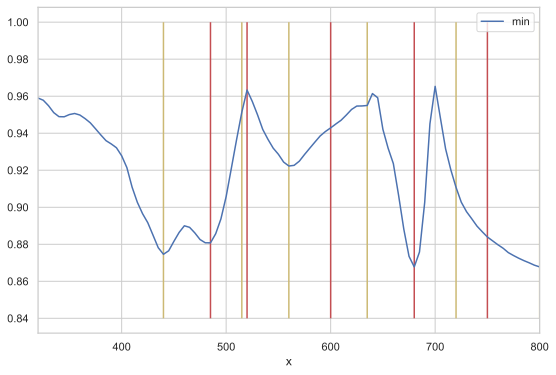

In [31]:
fig,ax = plt.subplots()
lambdas = [440, 485, 515, 520, 560, 600, 635, 680, 720, 750, 800]
corr_min.plot(x='x', y='min', ax=ax, figsize=(9,6))
ax.vlines(x=lambdas, ymin=0.840, ymax=1, colors=['y', 'r'] )